In [16]:
import numpy as np
import pandas as pd
import numpy as np
import glob as gb
import os
import keras_tuner as KT
import seaborn as sns
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from sklearn.utils import resample
from keras.losses import BinaryCrossentropy
from sklearn.ensemble import AdaBoostClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import BaggingClassifier
import copy
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
# Enable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [2]:
train_df = pd.read_csv('archive/train.csv',sep=" ",header=None)
train_df.columns=['patient id', 'filename', 'label','data source']
train_df=train_df.drop(['patient id', 'data source'], axis=1 )
train_df.head()

,filename,label
0,ARDSSevere.png,negative
1,acute-respiratory-distress-syndrome-ards-1.jpg,negative
2,acute-respiratory-distress-syndrome-ards.jpg,negative
3,ards-secondary-to-tiger-snake-bite.png,negative
4,pneumocystis-pneumonia-2-PA.png,negative


In [3]:
test_df = pd.read_csv('archive/test.csv',sep=" ",header=None)
test_df.columns=['patient id', 'filename', 'label','data source']
test_df=test_df.drop(['patient id', 'data source'], axis=1 )
test_df.head()

,filename,label
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive


In [4]:
train_p_count = train_df['label'].value_counts()['positive']
train_n_count = train_df['label'].value_counts()['negative']

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())
train_df = shuffle(train_df)


positive    15994
negative    13992
Name: label, dtype: int64
positive    200
negative    200
Name: label, dtype: int64


Train folder contains 29984 photos.
Test folder contains 400 photos.


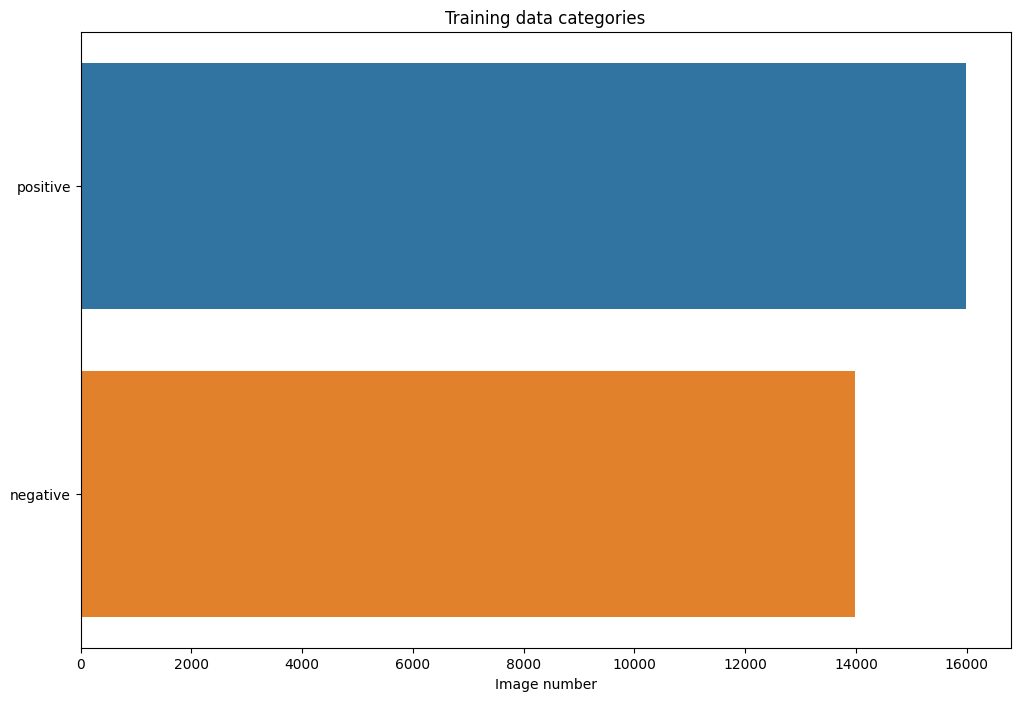

In [5]:
train_folder_path = 'archive/train'
test_folder_path = 'archive/test'

#Print out each folder's info

def count_photos(folder_path):
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            count +=1
    return count


def count_photos_in_folders(train_folder_path, test_folder_path):
    train_count = count_photos(train_folder_path)
    test_count = count_photos(test_folder_path)
    return (train_count, test_count)

# 将数据信息打印出来
# 2. Print out info for each dataset
train_count, test_count = count_photos_in_folders(train_folder_path, test_folder_path)

print(f"Train folder contains {train_count} photos.")
print(f"Test folder contains {test_count} photos.")

train_data_size = [train_p_count, train_n_count]
labels = ['positive', 'negative']

fig, axs = plt.subplots(figsize=(12, 8))
sns.barplot(x=train_data_size, y=labels, ax=axs)
axs.set_title('Training data categories')
axs.set(xlabel='Image number')
plt.show()




In [6]:
negative  = train_df[train_df['label']=='negative']   #negative values in class column
positive = train_df[train_df['label']=='positive']  #positive values in class column

df_majority_downsampled_neg = resample(negative, replace = True, n_samples = 5000)
df_majority_downsampled_pos = resample(positive, replace = True, n_samples = 5000)

train_df = pd.concat([df_majority_downsampled_pos, df_majority_downsampled_neg])
train_df = shuffle(train_df) # shuffling so that there is particular sequence

train_df, valid_df = train_test_split(train_df, train_size=0.8, random_state=0)

print(f"Negative and positive values of train:\n {train_df['label'].value_counts()}")
print(f"Negative and positive values of validation:\n {valid_df['label'].value_counts()}")
print(f"Negative and positive values of test:\n {test_df['label'].value_counts()}")

Negative and positive values of train:
 positive    4047
negative    3953
Name: label, dtype: int64
Negative and positive values of validation:
 negative    1047
positive     953
Name: label, dtype: int64
Negative and positive values of test:
 positive    200
negative    200
Name: label, dtype: int64


Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
{0: 'negative', 1: 'positive'}
fee72484-77b0-4d59-ad08-5d8f497dde99.png 1.0


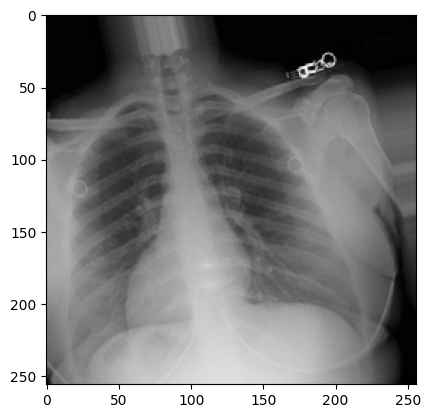

In [7]:
# 读取数据，把train分成train set和validation set，将batch size设置为64

train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

#Now fit the them to get the images from directory (name of the images are given in dataframe) with augmentation


train_gen = train_datagen.flow_from_dataframe(dataframe = train_df, directory='archive/train', x_col='filename', 
                                              y_col='label', target_size=(256,256), batch_size=64, 
                                               class_mode='binary')
val_gen = test_datagen.flow_from_dataframe(dataframe = valid_df, directory='archive/train', x_col='filename',
                                             y_col='label', target_size=(256,256), batch_size=64, 
                                            class_mode='binary')
test_gen = test_datagen.flow_from_dataframe(dataframe = test_df, directory='archive/test', x_col='filename', 
                                            y_col='label', target_size=(256,256), batch_size=64,
                                             class_mode='binary')
labels = {value: key for key, value in train_gen.class_indices.items()}
#class mode binary because we want the classifier to predict covid or not
#target size (200,200) means we want the images to resized to 200*200

#Examine the first image in the training dataset and print the label which corresponding to it.
print(labels)
images, labels = next(train_gen)
# Get the filenames associated with the images in the batch
filenames = train_gen.filenames
# Print the filename and label for the first image in the batch
print(filenames[0], labels[0])
# Plot the first image in the batch
plt.imshow(images[0])

In [ ]:

# Modeling
# Define the CNN model
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(
    32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
CNNmodel.add(layers.MaxPooling2D((2, 2)))

# Dropout rate was added to prevent overfitting.
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))

CNNmodel.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
# CNNmodel.add(layers.Dropout(0.25))

CNNmodel.add(layers.Conv2D(256, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
# CNNmodel.add(layers.Dropout(0.25))

CNNmodel.add(layers.GlobalAveragePooling2D())
CNNmodel.add(layers.Dense(64, activation='sigmoid'))
# CNNmodel.add(layers.Dropout(0.25))
CNNmodel.add(layers.Dense(1, activation='sigmoid'))
CNNmodel.summary()
# Compile the model with binary_crossentropy since it's a binary classification.
# Both technique will be employed in our tuning section
CNNmodel.compile(optimizer='Adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Train the model
history = CNNmodel.fit(train_gen,
                    epochs=10,
                    validation_data=val_gen)
                    # callbacks=[early_stop])

# Evaluate the model on the test set
test_loss, test_acc = CNNmodel.evaluate(test_gen, steps=test_gen.samples // test_gen.batch_size)

In [ ]:

#Draw the result output before tuning.

fig, ax = plt.subplots(nrows=2, figsize=(12, 10))
ax[0].set_title('Loss vs Epoch')
ax[0].plot(history.history['loss'], label='Training Loss', color='orange')
ax[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[1].set_title('Accuracy vs Epoch')
ax[1].plot(history.history['accuracy'], label='Training Accuracy', color='orange')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()
print('Test accuracy:', test_acc)


In [ ]:
#This part is used for tuning the CNN section, we will compare the CNN before and after tuning.


def build_model(hp):
    # Add layers
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation=hp.Choice('Activation Function', ['relu', 'tanh']), input_shape=(256, 256, 3)),
        layers.MaxPooling2D((2, 2)),

        # Dropout rate was added to prevent overfitting.
        layers.Conv2D(64, (3, 3), activation=hp.Choice('Activation Function', ['relu', 'tanh'])),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation=hp.Choice('Activation Function', ['relu', 'tanh'])),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(hp.Choice('Drop out Rate', [0.5, 0.25])),

        layers.Conv2D(256, (3, 3), activation=hp.Choice('Activation Function', ['relu', 'tanh'])),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(hp.Choice('Drop out Rate', [0.5, 0.25])),

        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation=hp.Choice('Activation Function', ['relu', 'tanh'])),
        layers.Dense(1, activation=hp.Choice('Output Activation Function', ['softmax', 'sigmoid']))
    ])

    opt = Adam(learning_rate=hp.Choice(
        'Learning Rate', values=[1e-3, 1e-4, 1e-5, 1e-6]))
    model.compile(optimizer=opt, loss='binary_crossentropy',
                  metrics=['accuracy'])
    # early_stop = EarlyStopping(monitor='val_loss', patience=5)
    # historyTuning = CNNmodel.fit(train_gen,
    #                 epochs=30,
    #                 validation_data=val_gen,
    #                 callbacks=[early_stop])

    return model



# 使用tuner来找出最佳的超参数组合，最佳的标准是拥有最好的validation accuracy，然后最多排列尝试次数是100次
# 4.Select best model
tuner = KT.RandomSearch(hypermodel=build_model, objective="val_accuracy", max_trials=20,
                        directory='./tuner', overwrite=True, project_name='Project_CNN_tuner')
tuner.search_space_summary()
# tuning过程的epoch设置成2（也就是每一种超参数的组合都run两次epoch），设置太大的话tuning过程会及其长
tuner.search(train_gen, epochs=2, validation_data=val_gen)
# 将validation accuracy最高的模型储存为best
best_model = tuner.get_best_models()[0]
# best model的summary
best_model.summary()
# 把模型储存在本地，这个模型是只加载CNN的情况下做好的tuning.
best_model.save('Best_CNN_Only')



In [ ]:

# ###### 做epoch30的统计图，选一个最佳 ######
# 加载储存了fine-tuning CNN的模型
best_model_only = keras.models.load_model('Best_CNN_only')
# 储存epoch 30的history信息
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = best_model_only.fit(train_gen,
                    epochs=10,
                    validation_data=val_gen,
                    callbacks=[early_stop])
# Evaluate the model on the test set
test_loss, test_acc = best_model_only.evaluate(test_gen, steps=test_gen.samples // test_gen.batch_size)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print(train_loss)
print(train_accuracy)
print(val_loss)
print(val_accuracy)
# 作两张图，training loss vs validation loss和training accuracy vs validation accuracy
# 以此判断在epoch大于多少时模型开始overfitting

fig, ax = plt.subplots(nrows=2, figsize=(12, 10))
ax[0].set_title('Loss vs Epoch')
ax[0].plot(history.history['loss'], label='Training Loss', color='orange')
ax[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[1].set_title('Accuracy vs Epoch')
ax[1].plot(history.history['accuracy'], label='Training Accuracy', color='orange')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()
print('Test accuracy:', test_acc)


In [ ]:
import numpy as np
from keras.models import clone_model
from keras.preprocessing.image import ImageDataGenerator

# Define your CNN model here
def create_model():
    model = keras.models.load_model('Best_CNN_only')
    return model


# Define the number of models in the ensemble
n_estimators = 3

# Create a list to store the models
models = []

# Train each model in the ensemble
for i in range(n_estimators):
    print(f'Training model {i + 1}')
    model = create_model()
    early_stop = EarlyStopping(monitor='val_loss', patience=3)
    model.fit(train_gen,
            epochs=10, 
            validation_data=val_gen，
            callbacks=[early_stop])
    models.append(model)
 
# Evaluate the ensemble on your test data
def ensemble_score(models, test_gen):
    scores = []
    
    for model in models:
        score = model.evaluate(test_gen)
        scores.append(score[1])  
    
    return np.mean(scores)

score = ensemble_score(models, test_gen)
print(f'Ensemble accuracy: {score}')


In [18]:
from keras.models import Model

# Load your fine-tuned CNN model
cnn_model = keras.models.load_model('Best_CNN_only')

# Remove the last layer to use the model as a feature extractor
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)
train_features = feature_extractor.predict(train_gen)
val_features = feature_extractor.predict(val_gen)
test_features = feature_extractor.predict(test_gen)


train_labels = np.concatenate([train_gen[i][1] for i in range(len(train_gen))])
val_labels = np.concatenate([val_gen[i][1] for i in range(len(val_gen))])
test_labels = np.concatenate([test_gen[i][1] for i in range(len(test_gen))])


base_estimator = DecisionTreeClassifier(max_depth=2)
adaboost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=20, learning_rate=0.001)

adaboost.fit(train_features, train_labels)
val_preds = adaboost.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_preds)

print(f"Validation accuracy: {val_accuracy}")

test_preds = adaboost.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_preds)

print(f"Test accuracy: {test_accuracy}")


7/7 [==============================] - 12s 2s/step
Validation accuracy: 0.4765
Test accuracy: 0.495
